In [17]:
import torch
import torch.cuda as cuda
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch.utils.data import DataLoader
import numpy as np
from torchvision import datasets
from torchvision import transforms
import torch.nn.functional as F

In [18]:
mean = 0.0
stddev = 1.0
transform=transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((mean), (stddev))])

mnist_train = datasets.MNIST('./data', train=True, download=True, transform=transform)
mnist_valid = datasets.MNIST('./data', train=False, download=True, transform=transform)

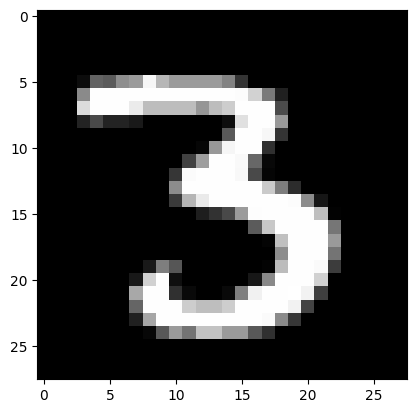

In [19]:

img = mnist_train[12][0].numpy().squeeze()

plt.imshow(img, cmap='gray')
plt.show()


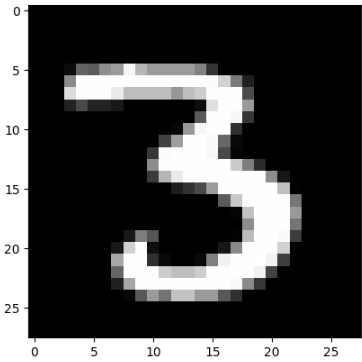

In [20]:
label = mnist_train[12][1]
print('Label of image above:', label)
# Reduce batch size if you get out-of-memory error
batch_size = 1024
mnist_train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=1)
mnist_valid_loader = torch.utils.data.DataLoader(mnist_valid, batch_size=batch_size, shuffle=True, num_workers=1)

Label of image above: 3


In [21]:
class CNN_Model(nn.Module):
    
    def __init__(self):
        super().__init__()
               
        # NOTE: All Conv2d layers have a default padding of 0 and stride of 1,
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)      # 24 x 24 x 20  (after 1st convolution)
        self.relu1 = nn.ReLU()                            # Same as above
        
        # Convolution Layer 2
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)     # 20 x 20 x 20  (after 2nd convolution)
        #self.conv2_drop = nn.Dropout2d(p=0.5)            # Dropout is a regularization technqiue we discussed in class
        self.maxpool2 = nn.MaxPool2d(2)                   # 10 x 10 x 20  (after pooling)
        self.relu2 = nn.ReLU()                            # Same as above 
        
        # Fully connected layers
        self.fc1 = nn.Linear(2000, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        
        # Convolution Layer 1                    
        x = self.conv1(x)                        
        x = self.relu1(x)                        
        
        # Convolution Layer 2
        x = self.conv2(x)               
        #x = self.conv2_drop(x)
        x = self.maxpool2(x)
        x = self.relu2(x)
        
        # Switch from activation maps to vectors
        x = x.view(-1, 2000)
        
        # Fully connected layer 1
        x = self.fc1(x)
        x = F.relu(x)
        #x = F.dropout(x, training=True)
        
        # Fully connected layer 2
        x = self.fc2(x)
        
        return x


In [22]:
# The model
net = CNN_Model()

if cuda.is_available():
    net = net.cuda()

# Our loss function
criterion = nn.CrossEntropyLoss()

# Our optimizer
learning_rate = 0.01
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

In [23]:
print(net)

CNN_Model(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu2): ReLU()
  (fc1): Linear(in_features=2000, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [24]:
num_epochs = 20

train_loss = []
valid_loss = []
train_accuracy = []
valid_accuracy = []

for epoch in range(num_epochs):
    
    ############################
    # Train
    ############################
    
    iter_loss = 0.0
    correct = 0
    iterations = 0
    
    net.train()                   # Put the network into training mode
    
    for i, (items, classes) in enumerate(mnist_train_loader):
        
        # Convert torch tensor to Variable
        items = Variable(items)
        classes = Variable(classes)
        
        # If we have GPU, shift the data to GPU
        if cuda.is_available():
            items = items.cuda()
            classes = classes.cuda()
        
        optimizer.zero_grad()     # Clear off the gradients from any past operation
        outputs = net(items)      # Do the forward pass
        loss = criterion(outputs, classes) # Calculate the loss
        iter_loss += loss.item() # Accumulate the loss
        loss.backward()           # Calculate the gradients with help of back propagation
        optimizer.step()          # Ask the optimizer to adjust the parameters based on the gradients
        
        # Record the correct predictions for training data 
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == classes.data).sum()
        iterations += 1
    
    # Record the training loss
    train_loss.append(iter_loss/iterations)
    # Record the training accuracy
    train_accuracy.append((100 * correct / float(len(mnist_train_loader.dataset))))
   

    ############################
    # Validate - How did we do on the unseen dataset?
    ############################
    
    loss = 0.0
    correct = 0
    iterations = 0
    net.eval()                    # Put the network into evaluate mode
    
    for i, (items, classes) in enumerate(mnist_valid_loader):
        
        # Convert torch tensor to Variable
        items = Variable(items)
        classes = Variable(classes)
        
        # If we have GPU, shift the data to GPU
        if cuda.is_available():
            items = items.cuda()
            classes = classes.cuda()
        
        outputs = net(items)      # Do the forward pass
        loss += criterion(outputs, classes).item() # Calculate the loss
        
        # Record the correct predictions for training data
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == classes.data).sum()
        
        iterations += 1

    # Record the validation loss
    valid_loss.append(loss/iterations)
    # Record the validation accuracy
    correct_scalar = np.array([correct.clone().cpu()])[0]
    valid_accuracy.append(correct_scalar / len(mnist_valid_loader.dataset) * 100.0)

    print ('Epoch %d/%d, Tr Loss: %.4f, Tr Acc: %.4f, Val Loss: %.4f, Val Acc: %.4f'
           %(epoch+1, num_epochs, train_loss[-1], train_accuracy[-1], 
             valid_loss[-1], valid_accuracy[-1]))

Epoch 1/20, Tr Loss: 1.5332, Tr Acc: 51.1050, Val Loss: 0.5489, Val Acc: 83.8800
Epoch 2/20, Tr Loss: 0.3833, Tr Acc: 88.5967, Val Loss: 0.3042, Val Acc: 91.0800
Epoch 3/20, Tr Loss: 0.2822, Tr Acc: 91.6683, Val Loss: 0.2375, Val Acc: 93.0500
Epoch 4/20, Tr Loss: 0.2268, Tr Acc: 93.2083, Val Loss: 0.1848, Val Acc: 94.5900
Epoch 5/20, Tr Loss: 0.1848, Tr Acc: 94.4583, Val Loss: 0.1594, Val Acc: 95.2500
Epoch 6/20, Tr Loss: 0.1512, Tr Acc: 95.4933, Val Loss: 0.1275, Val Acc: 96.2700
Epoch 7/20, Tr Loss: 0.1271, Tr Acc: 96.2733, Val Loss: 0.1143, Val Acc: 96.4300


In [ ]:
# save the model
torch.save(net.state_dict(), "./3.model.pth")

In [ ]:
# Plot loss curves
#điền ở đây

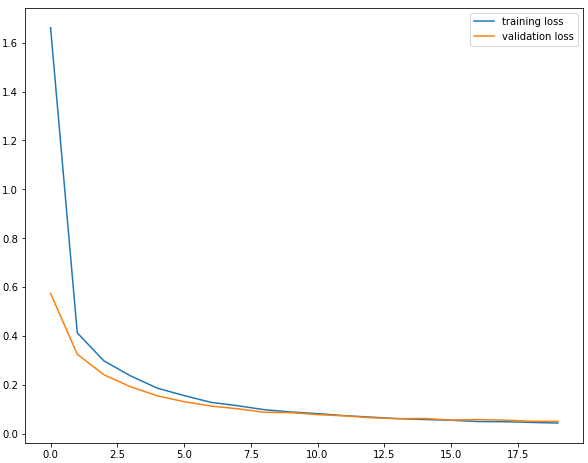

In [ ]:
# Plot accuracy curves
#điền ở đây

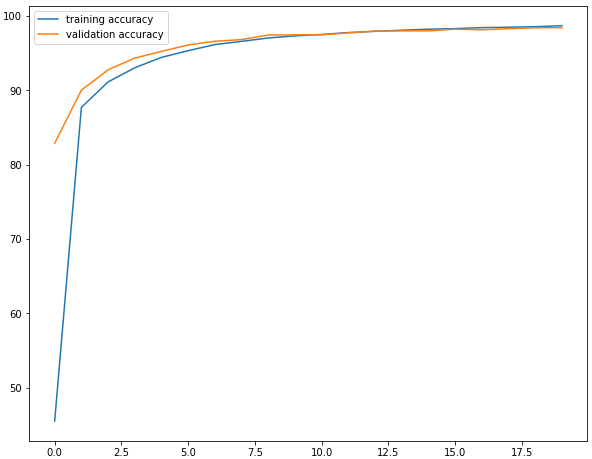

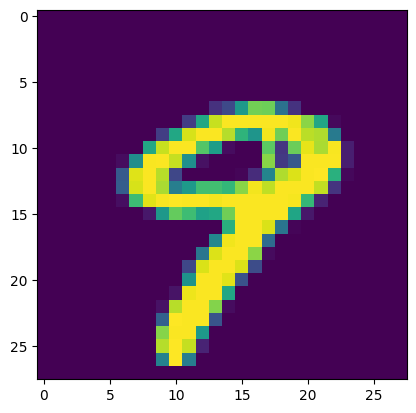

In [ ]:
image_index = 9
img = mnist_valid[image_index][0].resize_((1, 1, 28, 28))
img = Variable(img)
label = mnist_valid[image_index][1]
plt.imshow(img[0,0])
net.eval()

if cuda.is_available():
    net = net.cuda()
    img = img.cuda()
else:
    net = net.cpu()
    img = img.cpu()

output = net(img)

In [ ]:
output

tensor([[-5.9391, -8.8481, -6.2596,  2.3613,  6.5127, -2.9514, -9.0643,  5.3638,
          4.8984, 13.2129]], grad_fn=<AddmmBackward0>)

In [ ]:
_, predicted = torch.max(output.data, 1)
print("Predicted label:", predicted[0].item())
print("Actual label:", label)

Predicted label: 9
Actual label: 9
